In [1]:
import json
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

d:\anaconda\envs\gempy\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Not subsurface compatibility available


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
#please draw your X cross-section here
%run draw.py

pygame 2.4.0 (SDL 2.26.4, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


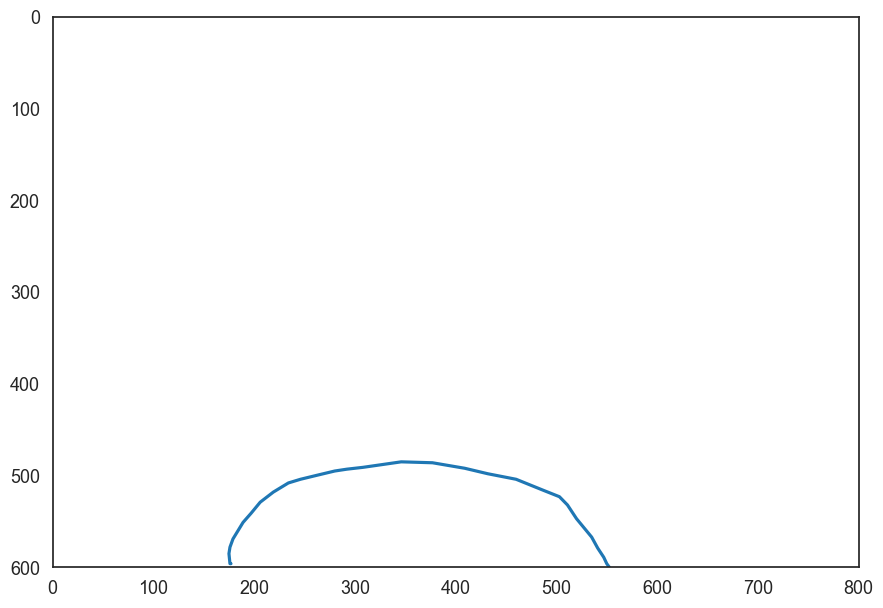

In [3]:
# Read points from the JSON file
with open("curve_points.json", "r") as file:
    points = json.load(file)
slice_x = np.array(points)[0]
fig, ax = plt.subplots()
ax.plot(slice_x[:, 0], slice_x[:, 1], "-")
ax.set_xlim(0, 800)
ax.set_ylim(0, 600)
ax.invert_yaxis()

In [4]:
#please draw your Y cross-section here
%run draw.py

<Figure size 1040x715 with 0 Axes>

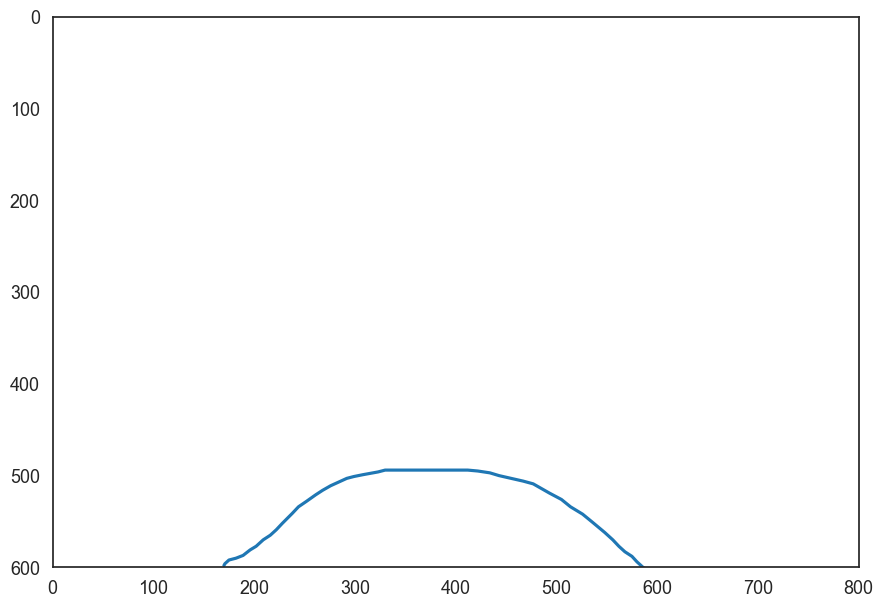

In [5]:
# Read points from the JSON file
with open("curve_points.json", "r") as file:
    points = json.load(file)
slice_y = np.array(points)[0]
fig, ax = plt.subplots()
ax.plot(slice_y[:, 0], slice_y[:, 1], "-")
ax.set_xlim(0, 800)
ax.set_ylim(0, 600)
ax.invert_yaxis()

In [6]:
# correct the position of the Y cross-section
slice_x_max = np.array([slice_x[:,0][slice_x[:,1]==slice_x[:,1].min()][0], slice_x[:,1].min()])
slice_y_max = np.array([slice_y[:,0][slice_y[:,1]==slice_y[:,1].min()][0], slice_y[:,1].min()])

diff = slice_x_max - slice_y_max
slice_y[:,1] = slice_y[:,1] + diff[1]


In [7]:
def set_input_data(slice_x, slice_y, slice_pos_1, slice_pos_2):

    x_slice = [slice_x[:,0],
                np.ones(len(slice_x))*slice_pos_1,
               -slice_x[:,1]]
    x_slice = pd.DataFrame((np.array(x_slice).T),columns=('X','Y','Z'))

    y_slice = [np.ones(len(slice_y))*slice_pos_2,
               slice_y[:,0],
               -slice_y[:,1]]
    y_slice = pd.DataFrame((np.array(y_slice).T),columns=('X','Y','Z'))

    formation = pd.DataFrame(data={'formation':['salt']*(len(x_slice) + len(y_slice))})

    surface = pd.concat([pd.concat([x_slice,y_slice],ignore_index=True),formation],axis=1)

    return surface

In [8]:
# calculate the orientation of the cross-section
def cal_orientation(x,y):
    x1 = y[1]-x[1]
    y1 = y[0]-x[0]
    
    return x1/np.sqrt(x1**2+y1**2), y1/np.sqrt(x1**2+y1**2)


In [9]:
# Sample array
array = list(range(slice_x.shape[0]))  # Creates a list from 0 to 100

# List to store the result
result_1 = []

# Iterate through the array to select 3 continuous numbers
for i in range(len(array)-1):
    # Select three continuous numbers and add them to the result list
    triplet = (array[i], array[i +1])
    result_1.append(triplet)

array = list(range(slice_y.shape[0]))  # Creates a list from 0 to 100

# List to store the result
result_2 = []

# Iterate through the array to select 3 continuous numbers
for i in range(len(array)-1):
    # Select three continuous numbers and add them to the result list
    triplet = (array[i], array[i +1])
    result_2.append(triplet)

In [10]:
def create_model():
    surface_points = set_input_data(slice_x, slice_y, slice_pos_1 = slice_y_max[0], slice_pos_2 = slice_x_max[0])
    geo_model = gp.create_model('salt')
    gp.init_data(geo_model, [0, 800, 0, 800, -600, 0], [50, 50, 50],
            surface_points_df = surface_points,
            default_values=False)
    geo_model.add_surfaces('basement')

    # for i in result:
    #     gp.set_orientation_from_surface_points(geo_model, np.array([i[0],i[1],i[2]]))
    # geo_model.set_default_orientation()
    # geo_model.add_orientations(slice_x_max[0],slice_y_max[0],-slice_x_max[1], surface ='salt',pole_vector =[0,0,1], orientation=[0,0,1])

#     geo_model.add_orientations(slice_x[10][0],slice_y_max[0],-slice_x[10][1], surface ='salt',pole_vector =[slice_x[11][1]-slice_x[10][1],0,slice_x[11][0]-slice_x[10][0]])

    #add orientations
    for i in result_1:
        geo_model.add_orientations(slice_x[i[0]][0],slice_y_max[0],-slice_x[i[0]][1], surface ='salt',pole_vector =[cal_orientation(slice_x[i[0]],slice_x[i[1]])[0],0,cal_orientation(slice_x[i[0]],slice_x[i[1]])[1]])

    for i in result_2:
        geo_model.add_orientations(slice_x_max[0],slice_y[i[0]][0],-slice_y[i[0]][1], surface ='salt',pole_vector =[0,cal_orientation(slice_y[i[0]],slice_y[i[1]])[0],cal_orientation(slice_y[i[0]],slice_y[i[1]])[1]])

    #plot results
    gp.plot_2d(geo_model, plotter_type='basic',show_data=True,legend=False,direction='y')
    gp.plot_2d(geo_model, plotter_type='basic',show_data=True,legend=False,direction='x')
    # gpv = gp.plot_3d(geo_model, image=True, plotter_type='basic',show_data=True)

    return geo_model

Active grids: ['regular']


d:\anaconda\envs\gempy\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
d:\anaconda\envs\gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


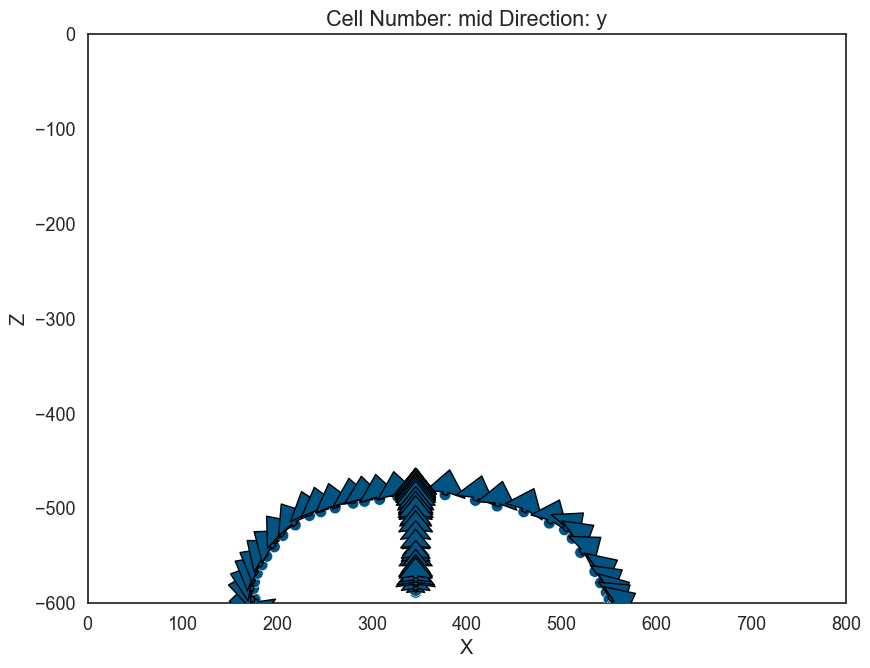

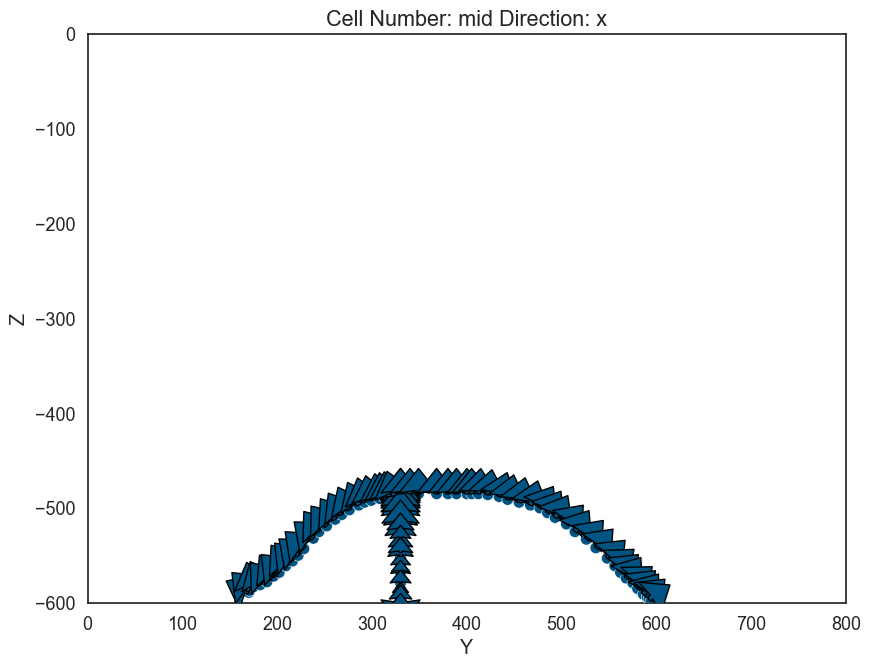

In [11]:
geo_model = create_model()

Setting kriging parameters to their default values.
Compiling theano function...


d:\anaconda\envs\gempy\lib\site-packages\theano\scan_module\scan_perform_ext.py:75: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  warnings.warn(
d:\anaconda\envs\gempy\lib\site-packages\theano\scan_module\scan_perform_ext.py:75: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  warnings.warn(
d:\anaconda\envs\gempy\lib\site-packages\theano\scan_module\scan_perform_ext.py:75: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                        values
range             1280.624847
$C_o$            39047.619048
drift equations           [3]


d:\anaconda\envs\gempy\lib\site-packages\pandas\plotting\_matplotlib\core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
d:\anaconda\envs\gempy\lib\site-packages\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


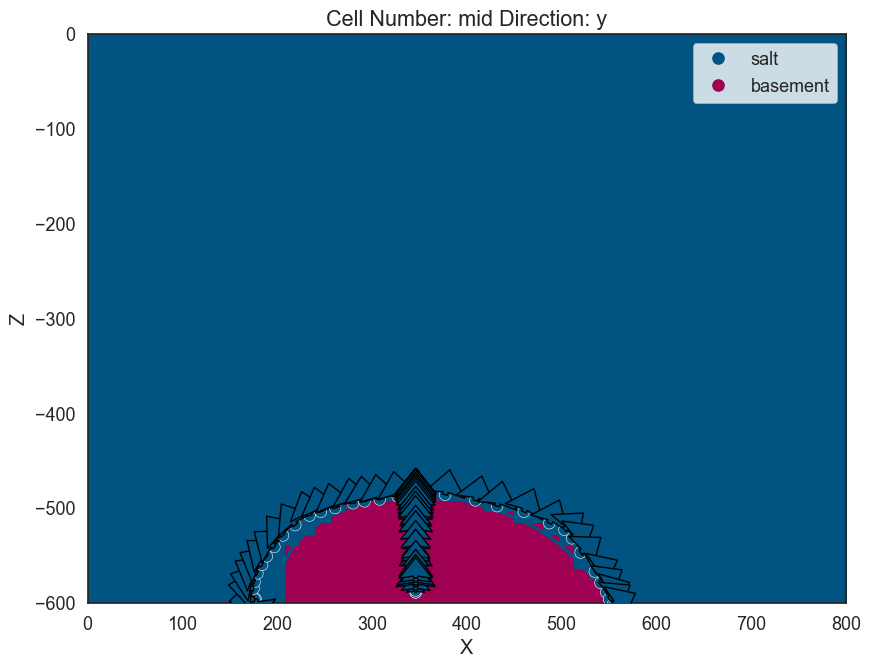

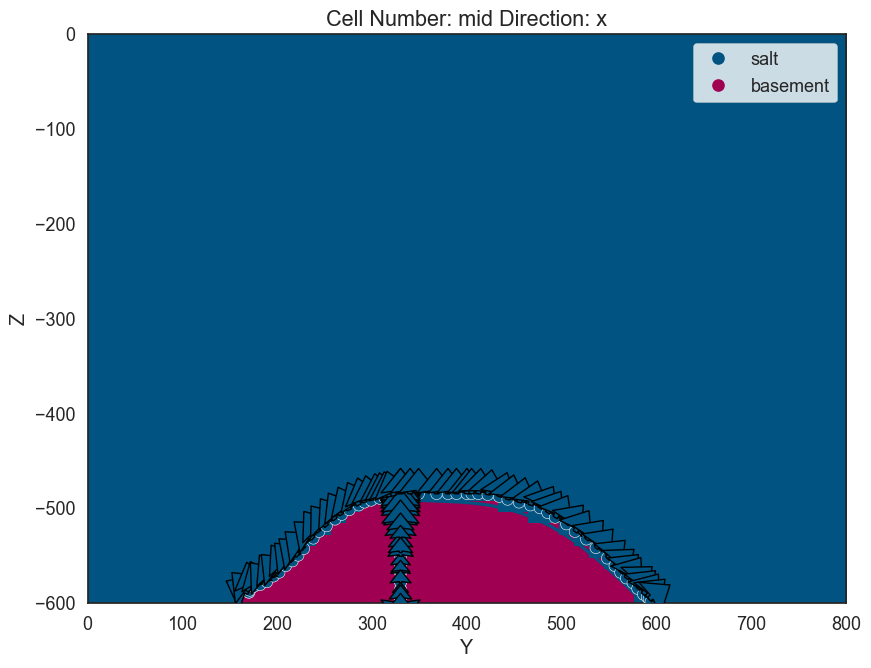

In [12]:
gp.set_interpolator(geo_model,
            compile_theano=True,
            theano_optimizer='fast_compile',
            )
sol = gp.compute_model(geo_model)
gp.plot_2d(geo_model, show_data=True,direction='y')
gp.plot_2d(geo_model, show_data=True,direction='x')
plt.show()

In [13]:
gpv = gp.plot_3d(geo_model, image=False, plotter_type='basic',show_data=False)

d:\anaconda\envs\gempy\lib\site-packages\pyvista\plotting\tools.py:571: PyvistaDeprecationWarning: The usage of `parse_color` is deprecated in favor of the new `Color` class.
  warnings.warn(


In [14]:
#please draw your X cross-section here
%run draw.py

<Figure size 1040x715 with 0 Axes>

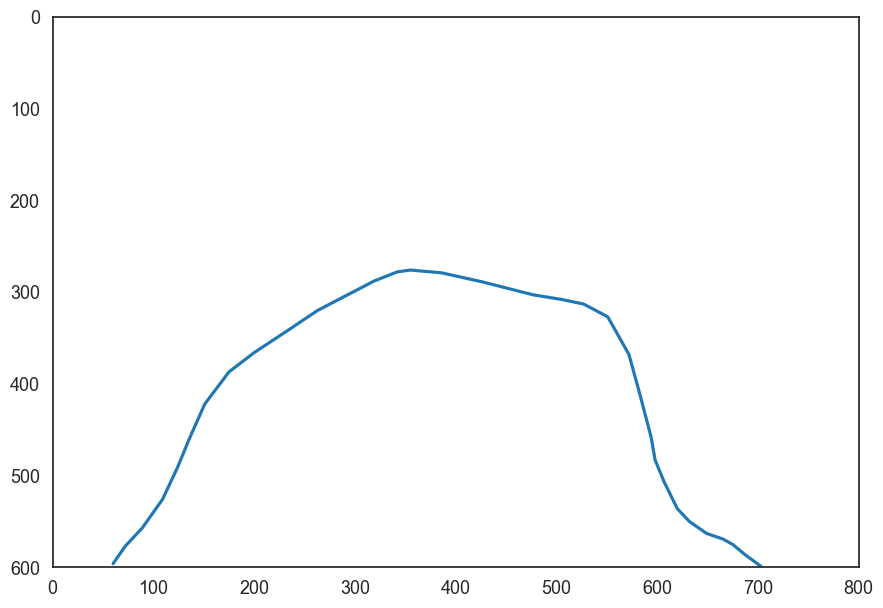

In [15]:
# Read points from the JSON file
with open("curve_points.json", "r") as file:
    points = json.load(file)
slice_x = np.array(points)[0]
fig, ax = plt.subplots()
ax.plot(slice_x[:, 0], slice_x[:, 1], "-")
ax.set_xlim(0, 800)
ax.set_ylim(0, 600)
ax.invert_yaxis()

In [16]:
#please draw your Y cross-section here
%run draw.py

<Figure size 1040x715 with 0 Axes>

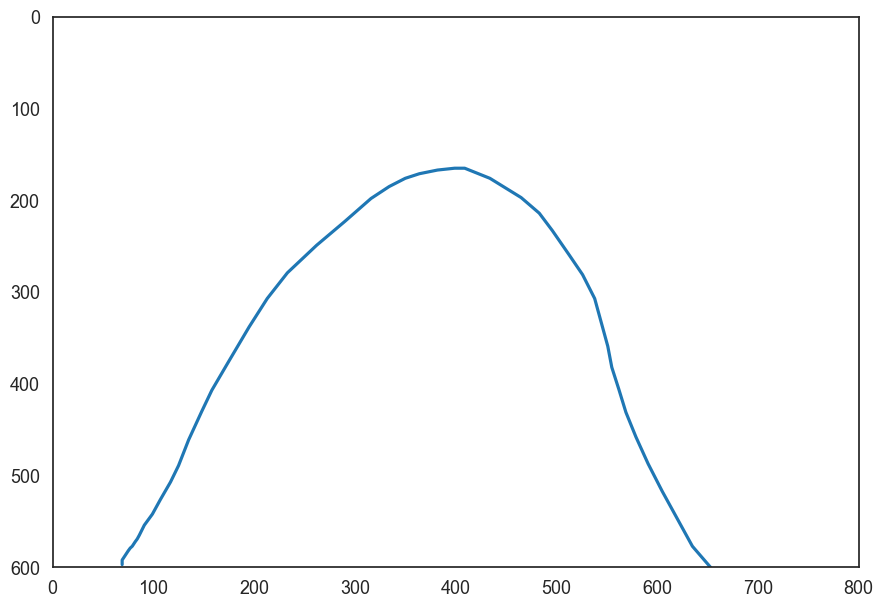

In [17]:
# Read points from the JSON file
with open("curve_points.json", "r") as file:
    points = json.load(file)
slice_y = np.array(points)[0]
fig, ax = plt.subplots()
ax.plot(slice_y[:, 0], slice_y[:, 1], "-")
ax.set_xlim(0, 800)
ax.set_ylim(0, 600)
ax.invert_yaxis()

In [18]:
# correct the position of the Y cross-section
slice_x_max = np.array([slice_x[:,0][slice_x[:,1]==slice_x[:,1].min()][0], slice_x[:,1].min()])
slice_y_max = np.array([slice_y[:,0][slice_y[:,1]==slice_y[:,1].min()][0], slice_y[:,1].min()])

diff = slice_x_max - slice_y_max
slice_y[:,1] = slice_y[:,1] + diff[1]

In [19]:
def set_input_data_2(slice_x, slice_y, slice_pos_1, slice_pos_2):

    x_slice = [slice_x[:,0],
                np.ones(len(slice_x))*slice_pos_1,
               -slice_x[:,1]]
    x_slice = pd.DataFrame((np.array(x_slice).T),columns=('X','Y','Z'))

    y_slice = [np.ones(len(slice_y))*slice_pos_2,
               slice_y[:,0],
               -slice_y[:,1]]
    y_slice = pd.DataFrame((np.array(y_slice).T),columns=('X','Y','Z'))

    formation = pd.DataFrame(data={'formation':['salt_2']*(len(x_slice) + len(y_slice))})

    surface = pd.concat([pd.concat([x_slice,y_slice],ignore_index=True),formation],axis=1)

    return surface

In [54]:
surface_2 = set_input_data_2(slice_x, slice_y, slice_pos_1 = slice_y_max[0], slice_pos_2 = slice_x_max[0])
surface_2

,X,Y,Z,formation
0,60.0,399.0,-596.0,salt_2
1,72.0,399.0,-577.0,salt_2
2,89.0,399.0,-557.0,salt_2
3,109.0,399.0,-526.0,salt_2
4,124.0,399.0,-491.0,salt_2
...,...,...,...,...
82,355.0,635.0,-688.0,salt_2
83,355.0,657.0,-716.0,salt_2
84,355.0,670.0,-740.0,salt_2
85,355.0,675.0,-747.0,salt_2


In [59]:
geo_model.add_surfaces('salt_2')

AttributeError: Can only use .cat accessor with a 'category' dtype

In [62]:
geo_model.add_surface_points(surface_2)

TypeError: add_surface_points() missing 3 required positional arguments: 'Y', 'Z', and 'surface'